# Diabetes Readmission – Graphical Exploration

This notebook explores the cleaned diabetes dataset visually to uncover patterns, potential predictors, and feature relationships associated with hospital readmission.

Our target variable is `readmitted`, indicating whether the patient returned to the hospital within 30 days.

We explore both categorical and continuous features, and consider feature-target interactions using visual EDA techniques.

## 1. Setup & Data Load

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('notebook', rc={'figure.figsize': (10, 8)})

from scipy.stats import ttest_ind
import missingno as msno

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="scipy")

In [2]:
data = pd.read_pickle('../models/ensemble.pkl')
initial_data = pd.read_pickle('../data/diabetes_clean.pkl')


In [3]:
# We transformed these columns in preprocessing, but we can pull them out of
# the initial data for graphical exploration.

# skew_cols = [
#     "num_medications",
#     "number_outpatient",
#     "number_emergency",
#     "number_inpatient",
#     "service_utilization",
#     "num_nondiabetic_medications",
# ]

data["num_medications"] = initial_data["num_medications"]
data["number_outpatient"] = initial_data["number_outpatient"]
data["number_emergency"] = initial_data["number_emergency"]
data["number_inpatient"] = initial_data["number_inpatient"]

initial_data["diabetes_meds_used"] = len(initial_data.iloc[:, 24:47].columns) - (
    initial_data[initial_data.iloc[:, 24:47].columns].isin(["No"])
).sum(axis=1)
initial_data["num_nondiabetic_medications"] = (
    initial_data["num_medications"] - initial_data["diabetes_meds_used"]
)

initial_data["diabetes_meds_used"].value_counts()  # nothing below zero.

data["num_nondiabetic_medications"] = (
    initial_data["num_medications"] - initial_data["diabetes_meds_used"]
)

data["service_utilization"] = (
    initial_data["number_inpatient"]
    + initial_data["number_outpatient"]
    + initial_data["number_emergency"]
)

In [4]:
# Create mapping dictionaries from the IDS_mapping.csv file
id_mappings_raw = pd.read_csv("../data/IDS_mapping.csv")

def wrap_at_space(text, max_length=20):
    """Break text at next space after max_length characters"""
    if len(text) <= max_length:
        return text

    # Find the next space after max_length
    space_pos = text.find(' ', max_length)
    if space_pos == -1:  # No space found, return original
        return text

    # Split at that space and recursively wrap the rest
    return text[:space_pos] + '\n' + wrap_at_space(text[space_pos+1:], max_length)

# Extract mappings by hardcoded row ranges
admission_type_map = {
    int(k): v if pd.notna(v) else "NULL"
    for k, v in zip(id_mappings_raw.iloc[0:8, 0], id_mappings_raw.iloc[0:8, 1])
    if pd.notna(k) and str(k).isdigit()
}
discharge_disposition_map = {
    int(k): v
    for k, v in zip(id_mappings_raw.iloc[12:38, 0], id_mappings_raw.iloc[12:38, 1])
    if pd.notna(k) and pd.notna(v) and str(k).isdigit()
}
admission_source_map = {
    int(k): wrap_at_space(v) if pd.notna(v) else "NULL"
    for k, v in zip(id_mappings_raw.iloc[40:67, 0], id_mappings_raw.iloc[40:67, 1])
    if pd.notna(k) and str(k).isdigit()
}

# Helper function to apply mappings to plots
def map_labels(series, mapping):
    """Apply ID to description mapping for plot labels"""
    return series.map(mapping).fillna(series.astype(str))

# Usage:
# sns.countplot(data=clean_data, x=map_labels(clean_data['admission_type_id'], admission_type_map))

## 2. Target Distribution

The goal is to understand:
- How imbalanced the readmitted target variable is 
- Whether this imbalance will influence model performance (especially for classification)

Before modeling, it's important to understand how balanced the target variable is. We compare the original 3-way readmission labels (`NO`, `>30`, `<30`) against the binary version used for modeling (`0` = not readmitted, `1` = readmitted within or after 30 days).

This lets us evaluate class imbalance and confirm that our binary simplification preserves clinical meaning while improving model usability.

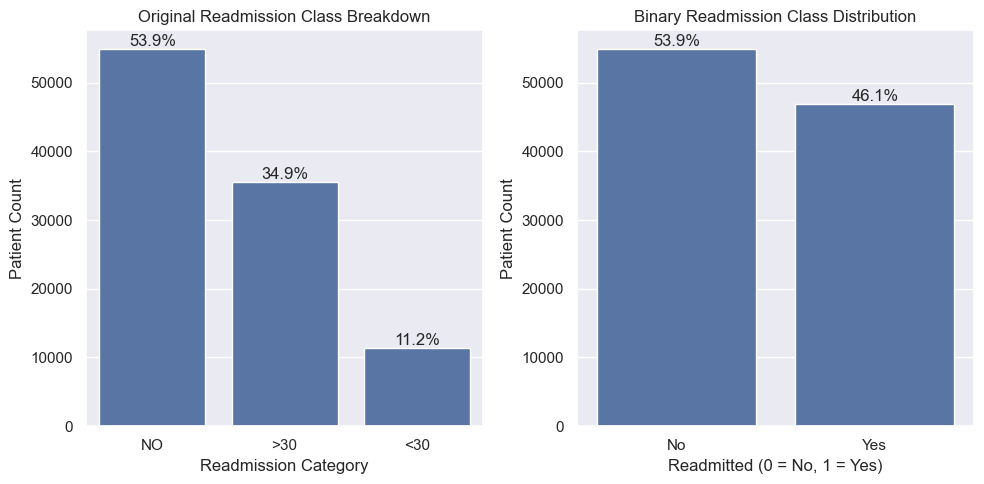

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Left plot - Original data
sns.countplot(x='readmitted', data=initial_data, ax=axes[0])
axes[0].set_title("Original Readmission Class Breakdown")
axes[0].set_xlabel("Readmission Category")
axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(['NO', '>30', '<30'])
axes[0].set_ylabel("Patient Count")

# Add percentage labels for left plot
total1 = len(initial_data)
for p in axes[0].patches:
    percentage = f'{100 * p.get_height() / total1:.1f}%'
    axes[0].annotate(percentage, (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='bottom')

# Right plot - Clean data
sns.countplot(x='readmitted', data=data, ax=axes[1])
axes[1].set_title("Binary Readmission Class Distribution")
axes[1].set_xlabel("Readmitted (0 = No, 1 = Yes)")
axes[1].set_ylabel("Patient Count")
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['No', 'Yes'])

# Add percentage labels for right plot
total2 = len(data)
for p in axes[1].patches:
    percentage = f'{100 * p.get_height() / total2:.1f}%'
    axes[1].annotate(percentage, (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 3. Categorical Features vs. Readmission

In this section, we explore how key categorical variables relate to the likelihood of hospital readmission.

The goal is to identify which demographic or clinical categories may be associated with higher readmission risk. This informs both feature selection and potential interactions to model.

We focus on the following categorical features:
- **Race**
- **Gender**
- **Age Group**
- **Admission Type**
- **Admission Source Group**
- **Discharge Disposition Group**

For each, we plot the distribution of readmission outcomes within each category.

### Readmission Count by Race

We begin by examining how readmission rates vary by patient race. While this may reflect structural disparities in healthcare, race alone is unlikely to be a strong standalone predictor — but it may interact with other variables.

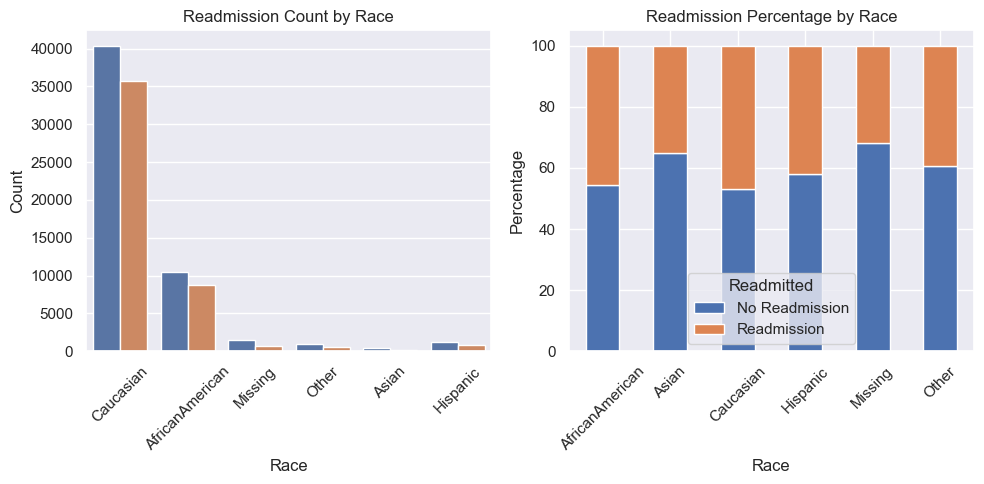

In [6]:
# Prepare data
ct = pd.crosstab(data['race'], data['readmitted'], normalize='index') * 100

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Left plot - Count plot using seaborn but on specific axis
sns.countplot(data=data, x='race', hue='readmitted', ax=axes[0], legend=False)
axes[0].set_title("Readmission Count by Race")
axes[0].set_xlabel("Race")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

# Right plot - Stacked percentage bar plot
ct.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title("Readmission Percentage by Race")
axes[1].set_xlabel("Race")
axes[1].set_ylabel("Percentage")
axes[1].legend(['No Readmission', 'Readmission'], title='Readmitted')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Readmission Rate by Gender

Next, we look at gender. Some studies show that male and female patients may have different healthcare utilization or outcomes, but this dataset shows relatively minor differences.

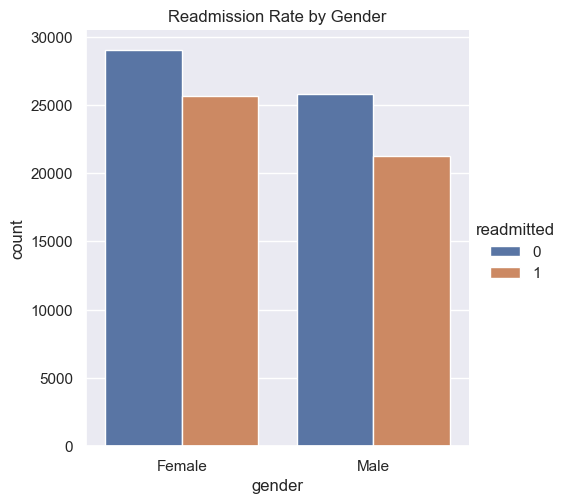

In [7]:
sns.catplot(data=data, x='gender', hue='readmitted', kind='count')
plt.title("Readmission Rate by Gender")
plt.show()

### Readmission by Age Group

We binned age into three clinically meaningful groups (`<30`, `30–60`, `>60`) and checked how readmission rates vary across them. Older patients show slightly higher risk, aligning with expectations.

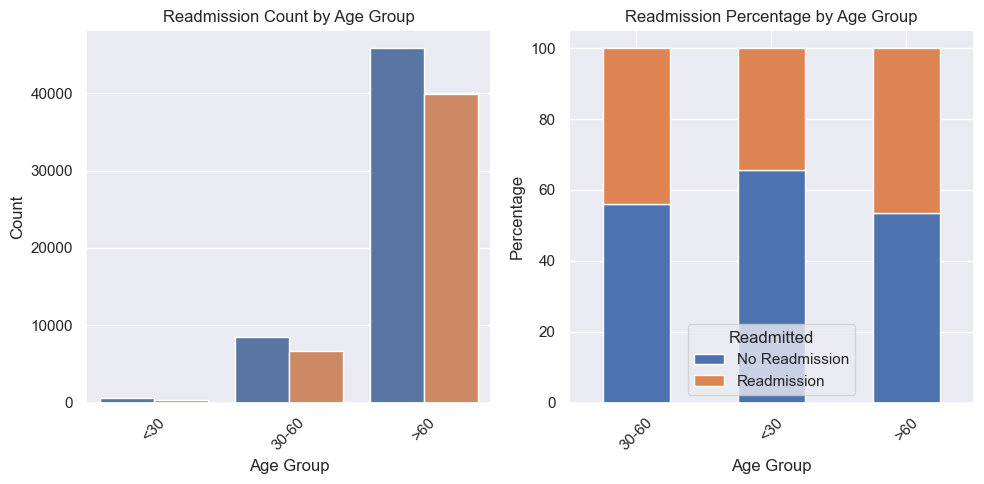

In [8]:
# Prepare data
ct = pd.crosstab(data['age_group'], data['readmitted'], normalize='index') * 100

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Left plot - Count plot using seaborn but on specific axis
sns.countplot(data=data, x='age_group', hue='readmitted', ax=axes[0], legend=False)
axes[0].set_title("Readmission Count by Age Group")
axes[0].set_xlabel("Age Group")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

# Right plot - Stacked percentage bar plot
ct.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title("Readmission Percentage by Age Group")
axes[1].set_xlabel("Age Group")
axes[1].set_ylabel("Percentage")
axes[1].legend(['No Readmission', 'Readmission'], title='Readmitted')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Readmission Rate by Admission Type ID

Admission type (e.g., emergency, urgent, elective) may correlate with acuity of condition and care complexity. Here, we see that emergency admissions have a modestly higher readmission rate.

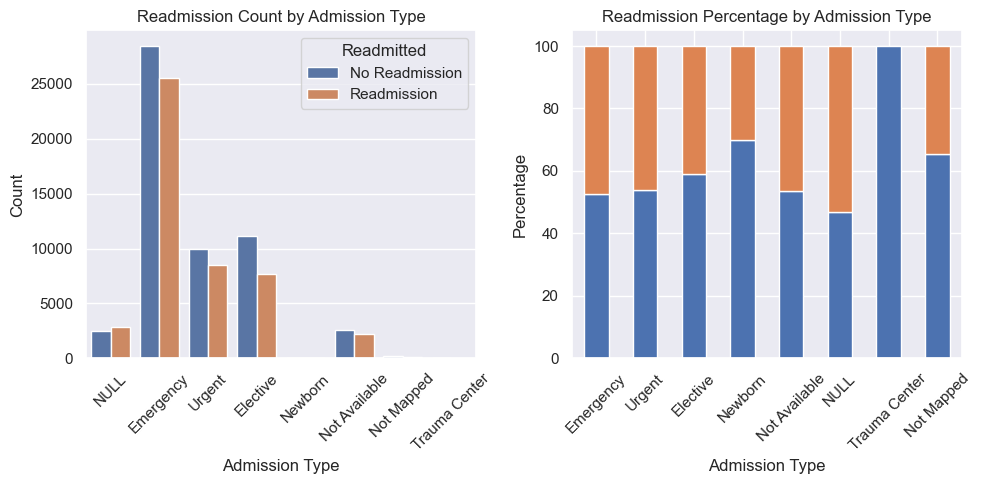

In [9]:
# plt.title("Readmission Rate by Admission Type ID")

# Prepare data
ct = pd.crosstab(data['admission_type_id'], data['readmitted'], normalize='index') * 100
ct.index = map_labels(ct.index.to_series(), admission_type_map)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Left plot - Count plot using seaborn but on specific axis
sns.countplot(data=data, 
              x=map_labels(data['admission_type_id'], admission_type_map), 
              hue='readmitted',
              ax=axes[0]) 
axes[0].set_title("Readmission Count by Admission Type")
axes[0].set_xlabel("Admission Type")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(['No Readmission', 'Readmission'], title='Readmitted')

# Right plot - Stacked percentage bar plot
ct.plot(kind='bar', stacked=True, ax=axes[1], legend=False)
axes[1].set_title("Readmission Percentage by Admission Type")
axes[1].set_xlabel("Admission Type")
axes[1].set_ylabel("Percentage")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Readmission by Admission Source Group

We use mapped descriptions from the `IDS_mapping.csv` to make this plot more interpretable. Admission source (e.g., referral, ER, transfer) reflects how patients entered the system, which can correlate with stability and follow-up risk.

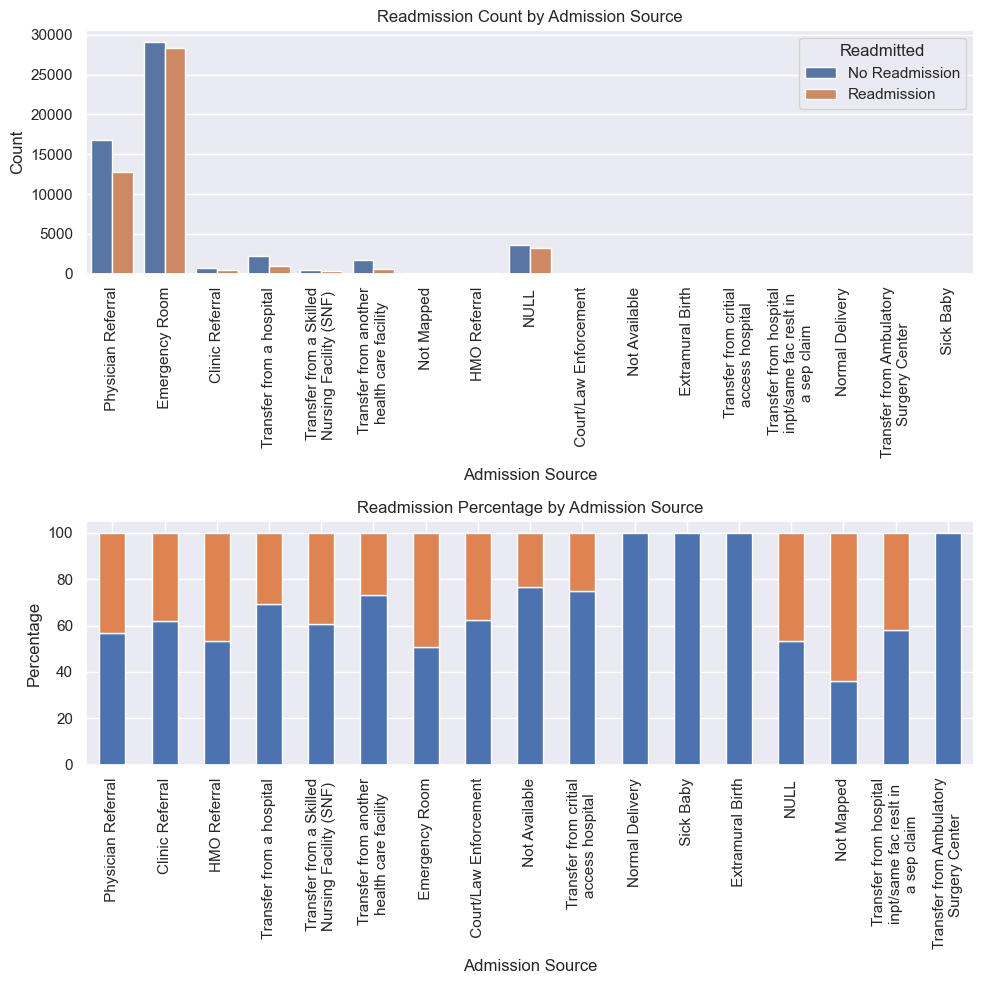

In [10]:
# plt.title("Readmission Rate by Admission Source ID")

# Prepare data
ct = pd.crosstab(data['admission_source_id'], data['readmitted'], normalize='index') * 100
ct.index = map_labels(ct.index.to_series(), admission_source_map)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Left plot - Count plot using seaborn but on specific axis
sns.countplot(data=data, 
              x=map_labels(data['admission_source_id'], admission_source_map), 
              hue='readmitted',
              ax=axes[0]) 
axes[0].set_title("Readmission Count by Admission Source")
axes[0].set_xlabel("Admission Source")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=90)
axes[0].legend(['No Readmission', 'Readmission'], title='Readmitted')

# Right plot - Stacked percentage bar plot
ct.plot(kind='bar', stacked=True, ax=axes[1], legend=False)
axes[1].set_title("Readmission Percentage by Admission Source")
axes[1].set_xlabel("Admission Source")
axes[1].set_ylabel("Percentage")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### Readmission by Discharge Disposition Group

Where a patient goes after discharge (e.g., home, skilled nursing, hospice) tells us a lot about their stability and level of care. Discharges to hospice or expired categories have lower readmission — for clear reasons — while discharges to home or facility transfers have more readmission variability.

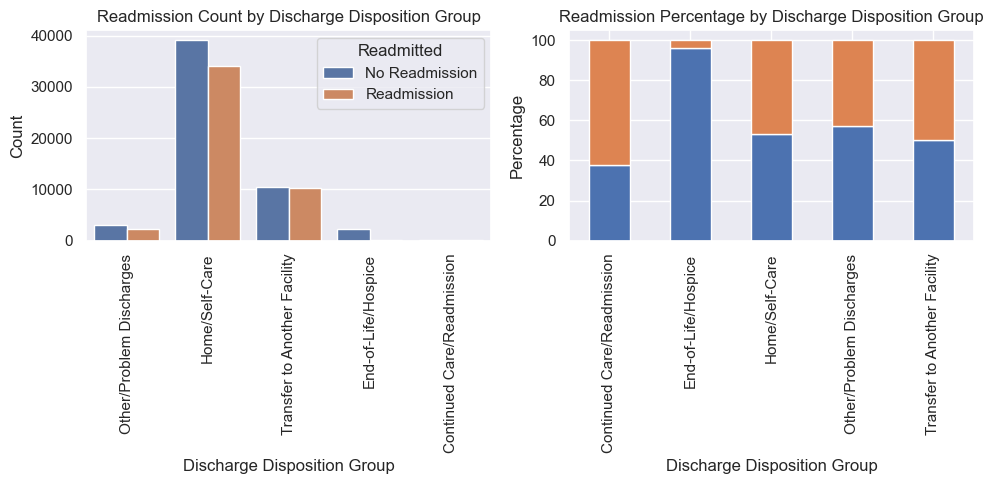

In [11]:
# Prepare data
ct = pd.crosstab(data['discharge_disposition_group'], data['readmitted'], normalize='index') * 100
ct.index = map_labels(ct.index.to_series(), discharge_disposition_map)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Left plot - Count plot using seaborn but on specific axis
sns.countplot(data=data, 
              x=map_labels(data['discharge_disposition_group'], discharge_disposition_map), 
              hue='readmitted',
              ax=axes[0]) 
axes[0].set_title("Readmission Count by Discharge Disposition Group")
axes[0].set_xlabel("Discharge Disposition Group")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=90)
axes[0].legend(['No Readmission', 'Readmission'], title='Readmitted')

# Right plot - Stacked percentage bar plot
ct.plot(kind='bar', stacked=True, ax=axes[1], legend=False)
axes[1].set_title("Readmission Percentage by Discharge Disposition Group")
axes[1].set_xlabel("Discharge Disposition Group")
axes[1].set_ylabel("Percentage")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

End of life / Hospice has pretty low readmission rates. :-(

## 4. Correlation Matrix

We will compute pairwise Pearson correlations among continuous numeric features to identify redundant signals, multicollinearity, and potential interactions. These can help set up bivariate explorations.

We focus especially on clinical utilization and treatment intensity variables. 

Text(0.5, 1.0, 'Correlation Matrix (Selected Numeric Features)')

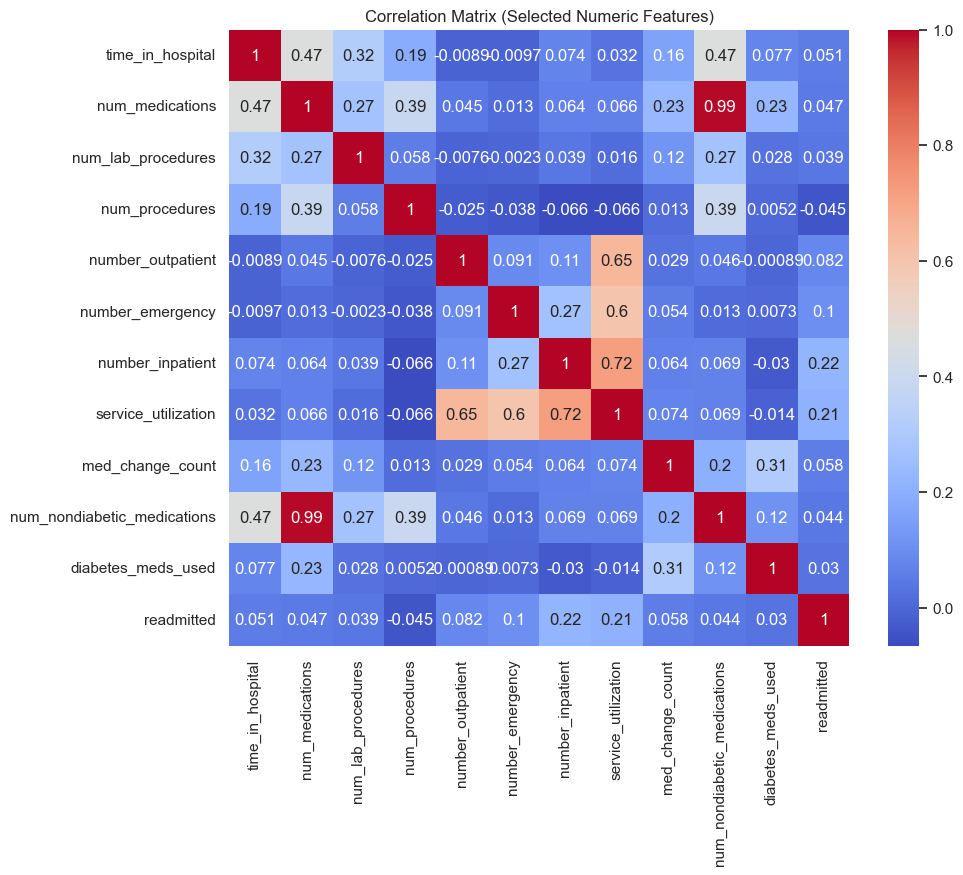

In [12]:
cols_of_interest = [
    "time_in_hospital", "num_medications", "num_lab_procedures", "num_procedures",
    "number_outpatient", "number_emergency", "number_inpatient",
    "service_utilization", "med_change_count", "num_nondiabetic_medications",
    "diabetes_meds_used", "readmitted"
]

sns.heatmap(data[cols_of_interest].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (Selected Numeric Features)")

The correlation matrix reveals a few moderate associations:

- The strongest collinearities exist in features we have engineered (service utilization and the three features it is generated from; medications & nondiabetic medications)
- Stronger than expected correlation between time in hospital and the number of medications, number of medications & number of procedures, 
- `readmitted` shows weak direct correlations with individual features, suggesting no single numeric predictor dominates

These patterns suggest a need for interaction modeling or tree-based techniques that can detect compound effects.

## 5. Bivariate Relationships

In this section, we explore how pairs of numeric features interact and whether their relationships vary by readmission status.

By plotting combinations of diagnostic tests, medication usage, and healthcare service encounters, we aim to detect clusters, correlations, or nonlinear patterns that may not emerge when examining single features in isolation.

### Lab Procedures vs. Medications

This Kernel Density Estimate plot shows a general positive correlation — more lab procedures often accompany higher medication counts. Readmitted patients don’t show a dramatically different distribution here.

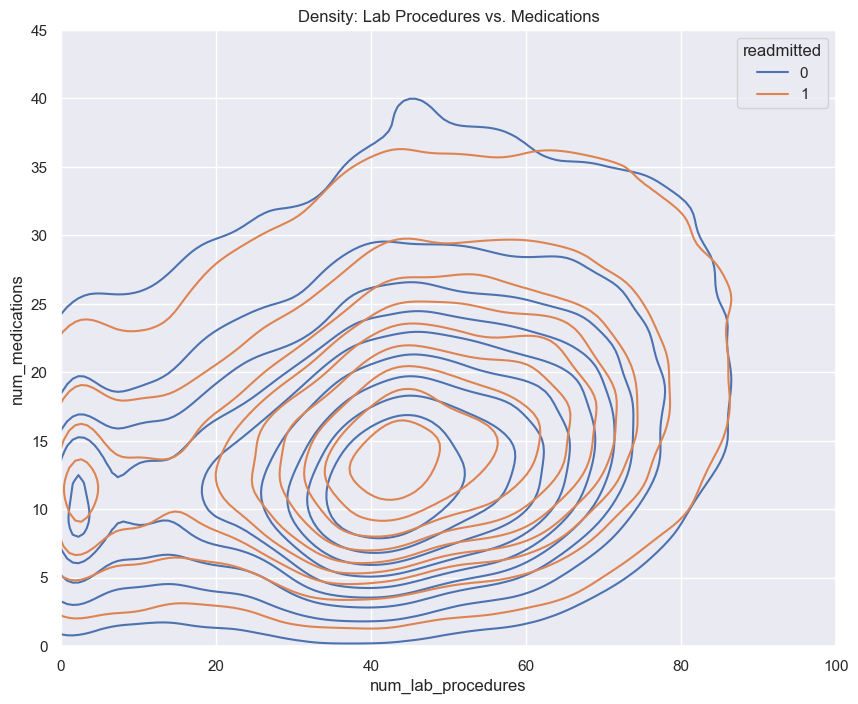

In [13]:
sns.kdeplot(data=data, 
    x='num_lab_procedures', 
    y='num_medications',
    hue='readmitted', 
    )
plt.ylim(0, 45)
plt.xlim(0, 100)

plt.title("Density: Lab Procedures vs. Medications")
plt.show()

### Time in hospital vs. number of medications

These two features correlate very well together, and don't show any dramatic differences in readmissions.

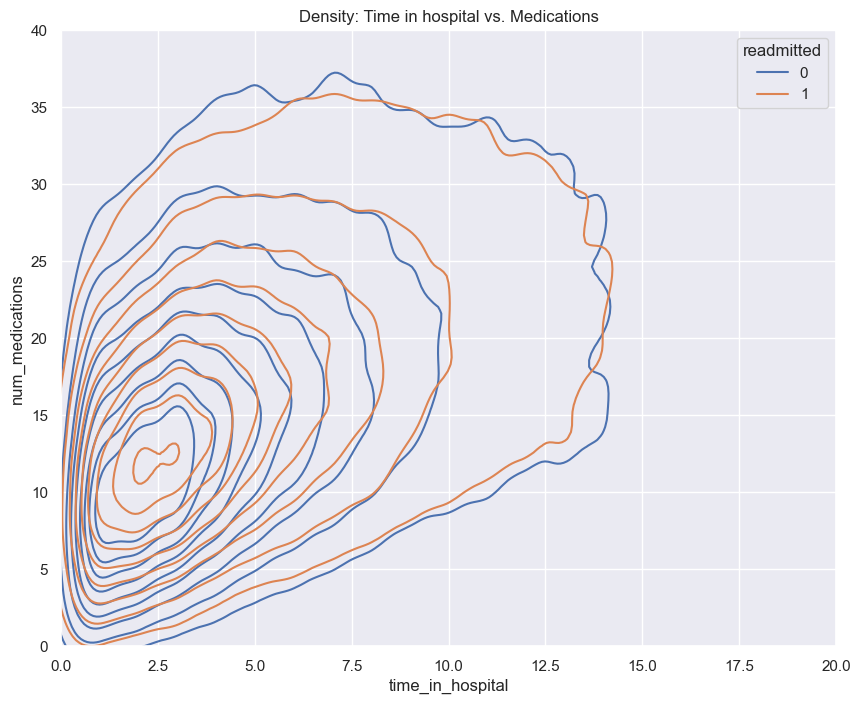

In [14]:
sns.kdeplot(data=data, 
    x='time_in_hospital', 
    y='num_medications',
    hue='readmitted', 
    )
plt.ylim(0, 40)
plt.xlim(0, 20)

plt.title("Density: Time in hospital vs. Medications")
plt.show()

### Outpatient vs. Inpatient Visits

This plot compares two prior-year utilization metrics. Patients with many outpatient and inpatient visits are more likely to be complex or chronically ill — and we see more readmissions the further along each of these axes we go. 

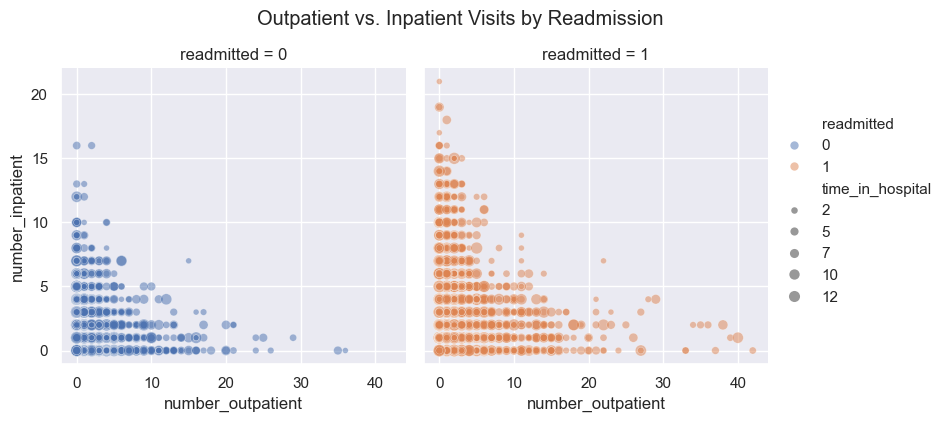

In [15]:
sns.relplot(data=data, x='number_outpatient', y='number_inpatient',
            hue='readmitted', col='readmitted', 
            size='time_in_hospital',
            kind='scatter',
            alpha=0.5, height=4)

plt.suptitle("Outpatient vs. Inpatient Visits by Readmission", y=1.05)
plt.show()

### Diagnoses vs. Medications

Here, we explore the relationship between diagnostic complexity and medication load. There’s a loose positive trend, but little visual separation by readmission status — which suggests potential value from tree-based models or interaction terms.

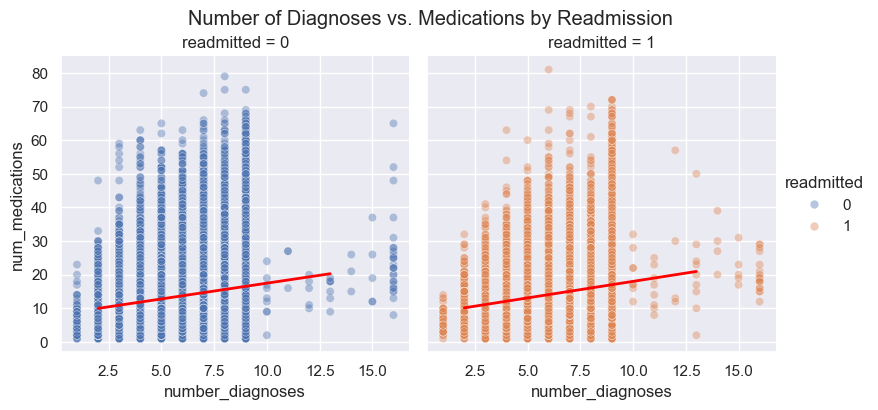

In [16]:
g = sns.relplot(data=data, x='number_diagnoses', y='num_medications',
                hue='readmitted', col='readmitted',
                kind='scatter', alpha=0.4, height=4)

# Get unique readmitted values in the same order as the plot
readmitted_values = data['readmitted'].unique()

for i, ax in enumerate(g.axes.flat):
    readmitted_value = readmitted_values[i]

    # Filter data for this specific readmission group
    mask = data['readmitted'] == readmitted_value
    subset_data = data[mask].copy()

    # Remove outliers using IQR method to prevent numerical issues
    x_col, y_col = 'number_diagnoses', 'num_medications'

    for col in [x_col, y_col]:
        Q1 = subset_data[col].quantile(0.25)
        Q3 = subset_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        subset_data = subset_data[(subset_data[col] >= lower) & (subset_data[col] <= upper)]

    # Check if we still have enough valid data
    if len(subset_data) > 10:  # Need more points for stable regression
        # Use numpy polyfit for more robust regression
        try:
            x_vals = subset_data[x_col].values
            y_vals = subset_data[y_col].values

            # Fit linear regression manually
            coeffs = np.polyfit(x_vals, y_vals, 1)
            x_line = np.linspace(x_vals.min(), x_vals.max(), 100)
            y_line = coeffs[0] * x_line + coeffs[1]

            ax.plot(x_line, y_line, color='red', linewidth=2)

        except (np.linalg.LinAlgError, np.RankWarning):
            print(f"Skipping regression for readmitted={readmitted_value} - numerical issues")

plt.suptitle("Number of Diagnoses vs. Medications by Readmission", y=1.02)
plt.show()

The prevalence of 9 diagnoses for the patient entered into the system is interesting. We know that diabetes mellitus is a diagnosis that was required to make it into the original data set to begin with; it's possible that most of the coding/intake systems used to generate the data in the first place had a limit of 10.

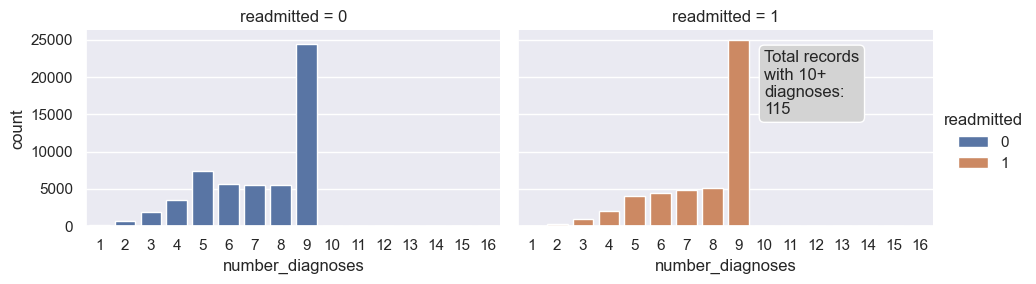

In [17]:
sns.catplot(data=data, x="number_diagnoses",hue='readmitted', col='readmitted', kind='count', height=3, aspect=1.6)
# Add text (x, y are in data coordinates)
plt.text(x=9, y=15000, s=f"Total records\nwith 10+\ndiagnoses:\n{len(data.loc[data['number_diagnoses'] >= 10, 'number_diagnoses'])}",
        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
plt.show()

## 6. Clinical Specialty & Service Patterns

We now shift focus to how clinical operations and treatment behavior relate to hospital readmission.

This includes:
- Duration of the hospital stay
- The specialty of the treating physician
- Laboratory test results for glucose and A1C
- Changes to diabetic medications
- Substitution behavior
- Medication load
- Overall service utilization in the prior year

These variables offer deeper insight into the **clinical stability** and **care pathways** experienced by patients — and may yield strong predictive power for readmission risk.

### Readmission by duration of the hospital stay

As expected, patients with longer hospital stays show slightly elevated readmission risk.

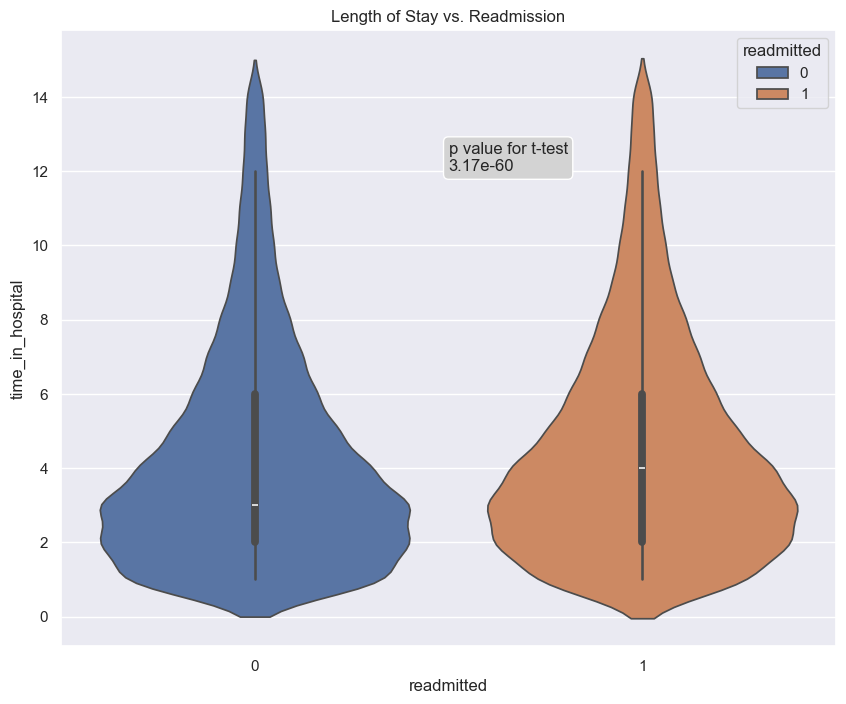

In [18]:
# Perform independent t-test
_, p_value = ttest_ind(data[data['readmitted'] == 0]['time_in_hospital'], data[data['readmitted'] == 1]['time_in_hospital'])

sns.violinplot(data=data, x='readmitted', y='time_in_hospital', hue='readmitted', bw_adjust=1.5)
plt.title("Length of Stay vs. Readmission")
plt.text(x=0.5, y=12, s=f"p value for t-test\n{p_value:.2e}",
        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
plt.show()

### Number of lab procedures

Patients undergoing more lab procedures might have slightly higher readmission rates, suggesting a mild correlation with diagnostic complexity or monitoring intensity.

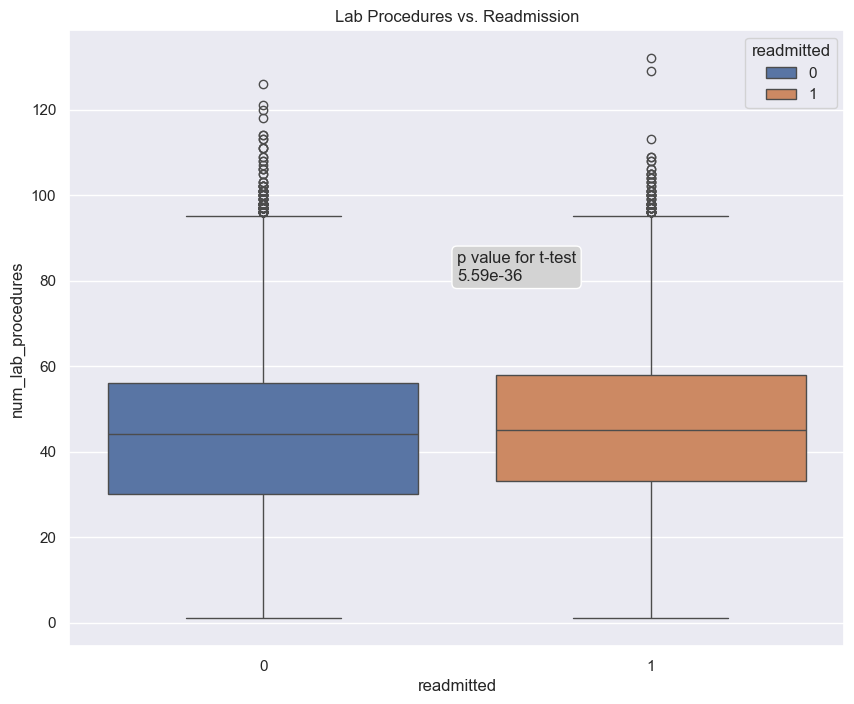

In [19]:
# Perform independent t-test
_, p_value = ttest_ind(data[data['readmitted'] == 0]['num_lab_procedures'], data[data['readmitted'] == 1]['num_lab_procedures'])

sns.boxplot(data=data, x='readmitted', y='num_lab_procedures', hue='readmitted')
plt.text(x=0.5, y=80, s=f"p value for t-test\n{p_value:.2e}",
        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
plt.title("Lab Procedures vs. Readmission")
plt.show()

### Number of non-lab procedures

Procedure count alone shows limited differentiation in readmission rates, likely due to many patients receiving few or no procedures during their stay.

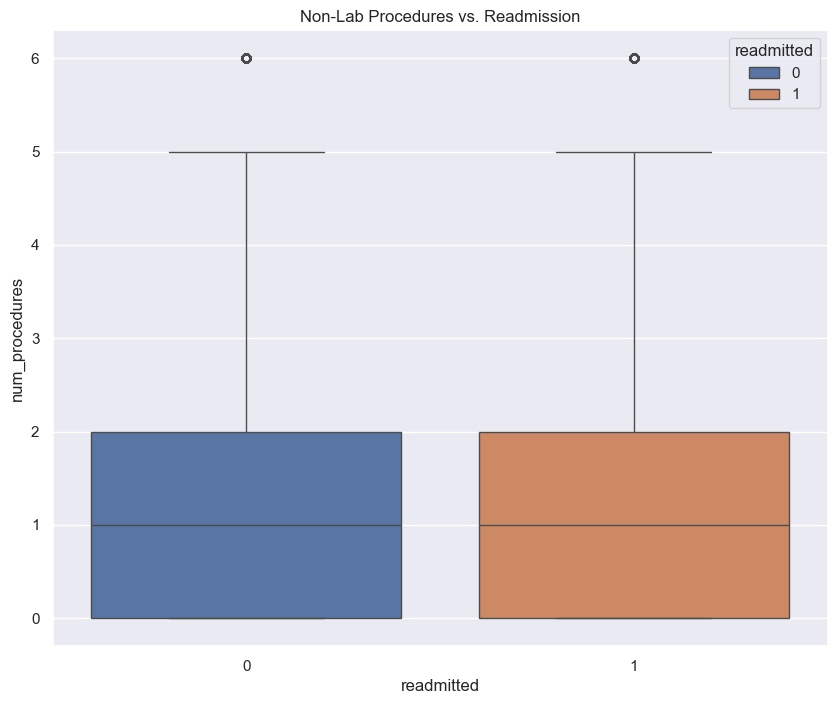

In [20]:
sns.boxplot(data=data, x='readmitted', y='num_procedures', hue='readmitted')
plt.title("Non-Lab Procedures vs. Readmission")
plt.show()

### Readmission by Medical Specialty

Internal Medicine has the highest number of readmissions, likely reflecting the complexity and chronic nature of the patients it serves, such as those with diabetes and multiple comorbidities. Emergency/Trauma shows a higher readmission rate relative to its patient volume, which maybe is not surprising given what they do. Note that many missing records were removed for this plot.

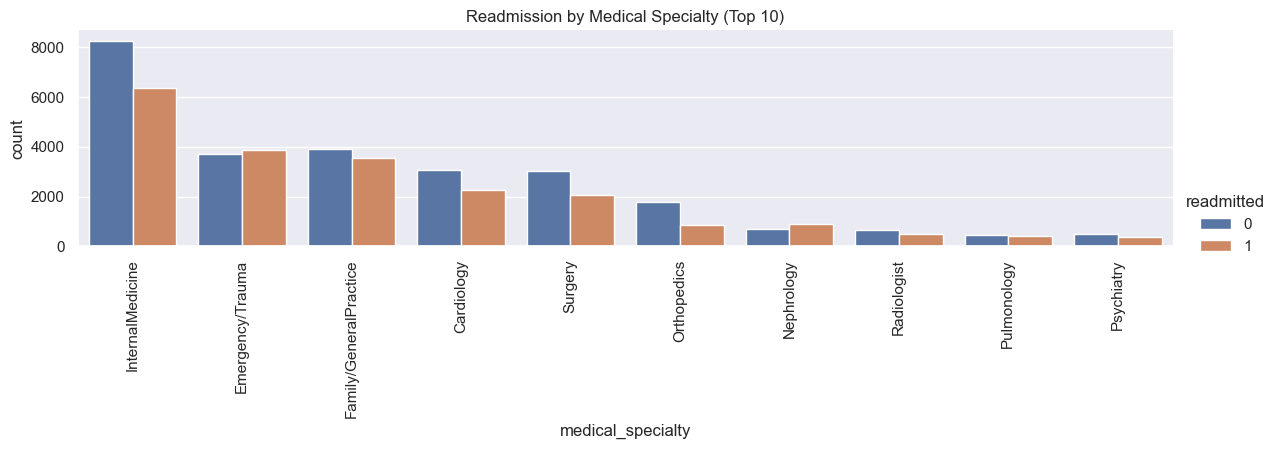

In [21]:
top_specialties = data['medical_specialty'].value_counts().nlargest(11).index[1:11].tolist()
sns.catplot(data=data[data['medical_specialty'].isin(top_specialties)],
            x='medical_specialty', hue='readmitted', order=top_specialties, kind='count', height=3, aspect=4)
plt.xticks(rotation=90)
plt.title("Readmission by Medical Specialty (Top 10)")
plt.show()

### Readmission by A1C Result & Glucose Level

These laboratory results are significantly missing. Although a glucose serum level exceeding 300 appears to indicate a high readmission risk, the high missingness rate renders this information inactionable. Even when present, the marginal readmission signal associated with A1C appears weak in this dataset. It is possible that A1C exhibits a strong interaction with other features.

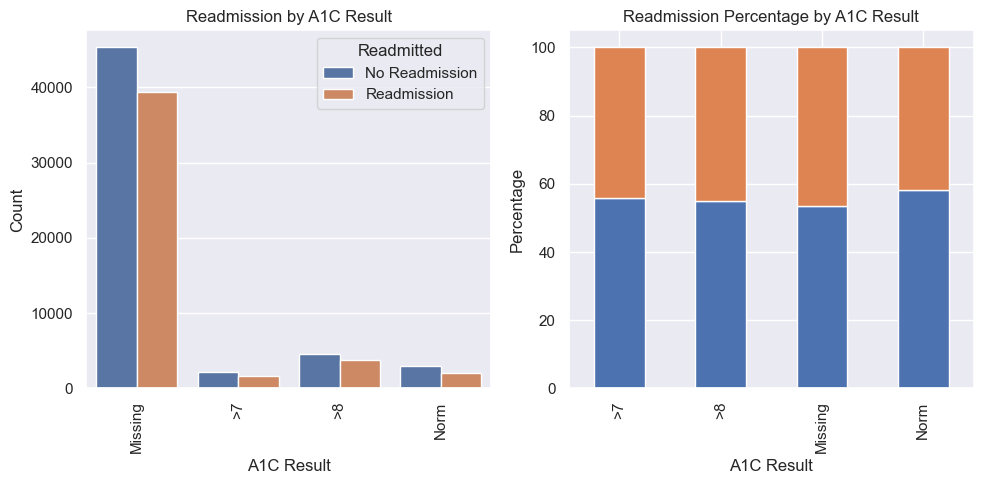

In [22]:
# Prepare data
ct = pd.crosstab(data['A1Cresult'], data['readmitted'], normalize='index') * 100

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Left plot - Count plot using seaborn but on specific axis
sns.countplot(data=data, 
              x=data['A1Cresult'], 
              hue='readmitted',
              ax=axes[0]) 
axes[0].set_title("Readmission by A1C Result")
axes[0].set_xlabel("A1C Result")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=90)
axes[0].legend(['No Readmission', 'Readmission'], title='Readmitted')

# Right plot - Stacked percentage bar plot
ct.plot(kind='bar', stacked=True, ax=axes[1], legend=False)
axes[1].set_title("Readmission Percentage by A1C Result")
axes[1].set_xlabel("A1C Result")
axes[1].set_ylabel("Percentage")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

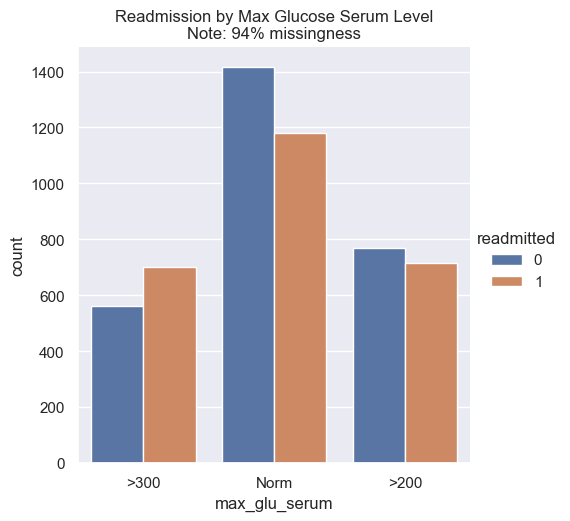

In [23]:
sns.catplot(
    data=data[data["max_glu_serum"] != "Missing"],
    x="max_glu_serum",
    hue="readmitted",
    kind="count",
)
plt.title("Readmission by Max Glucose Serum Level\nNote: 94% missingness")
plt.show()

### Readmission by Medication changes & Medcation Substitution 

Both absolute medication changes and substitution behavior show modest signal. Patients with no changes may represent stable or undertreated cases, while those with many changes could reflect poorly controlled disease.

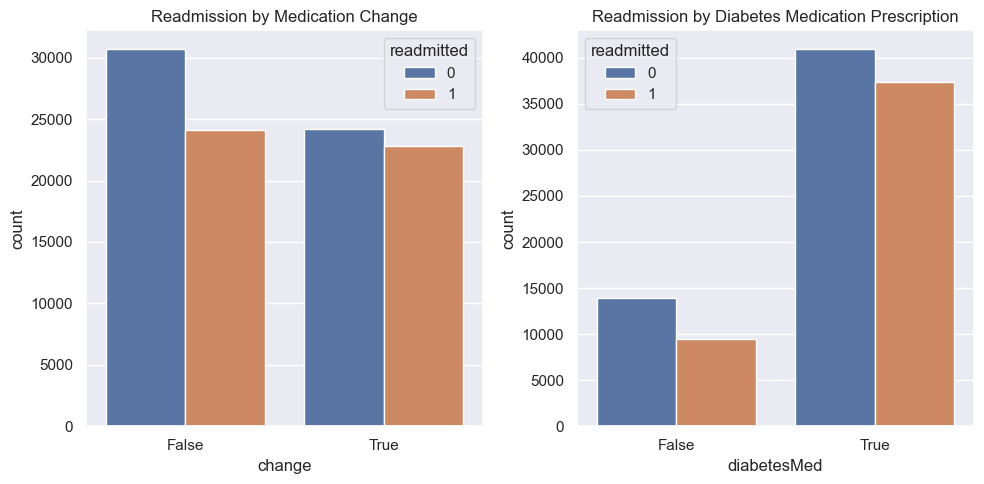

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(data=data, x='change', hue='readmitted', ax=axes[0])
axes[0].set_title("Readmission by Medication Change")

sns.countplot(data=data, x='diabetesMed', hue='readmitted', ax=axes[1])
axes[1].set_title("Readmission by Diabetes Medication Prescription")

plt.tight_layout()
plt.show()

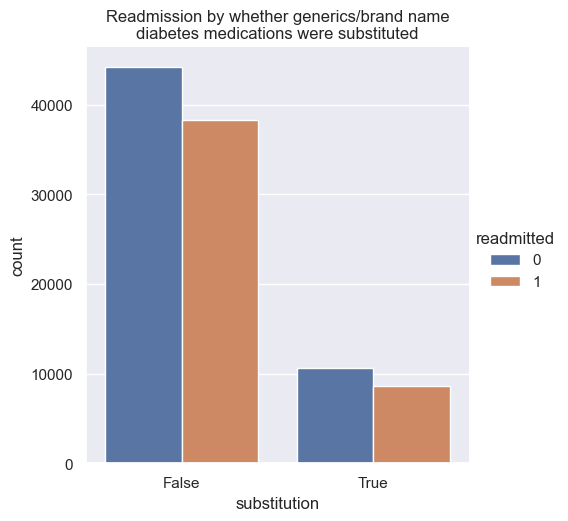

In [25]:
sns.catplot(
    data=data,
    x="substitution",
    hue="readmitted",
    kind="count",
)
plt.title("Readmission by whether generics/brand name\ndiabetes medications were substituted")
plt.show()

### Readmission by medication load

We differentiate between total medications and diabetes-specific meds. Higher counts generally correlate with more complex care and slightly higher readmission, but with wide variance.

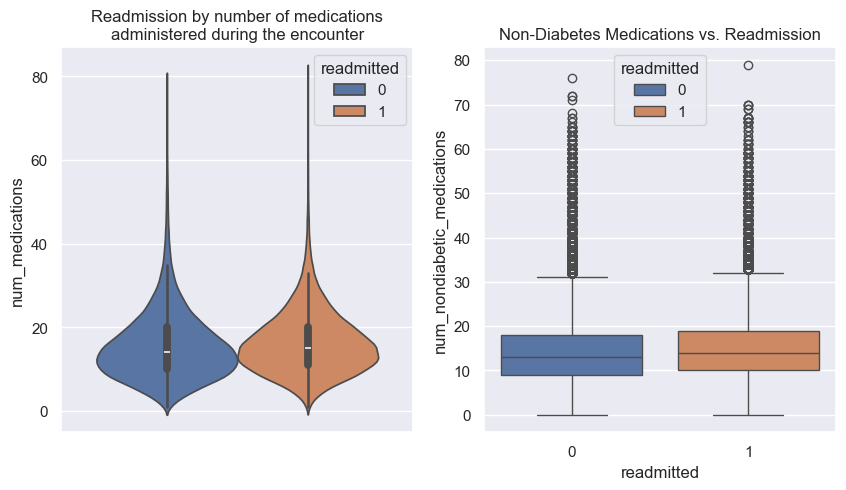

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.violinplot(data=data, y="num_medications", hue="readmitted", ax=axes[0])
axes[0].set_title(
    "Readmission by number of medications\nadministered during the encounter"
)

sns.boxplot(
    data=data,
    x="readmitted",
    y="num_nondiabetic_medications",
    hue="readmitted",
    ax=axes[1],
)
axes[1].set_title("Non-Diabetes Medications vs. Readmission")

plt.show()

### Readmission by Overall Service Utilization in the Prior Year

Patients with more total visits across inpatient, outpatient, and emergency care tend to show higher readmission risk, though the distribution is heavily skewed with many low-utilization patients.

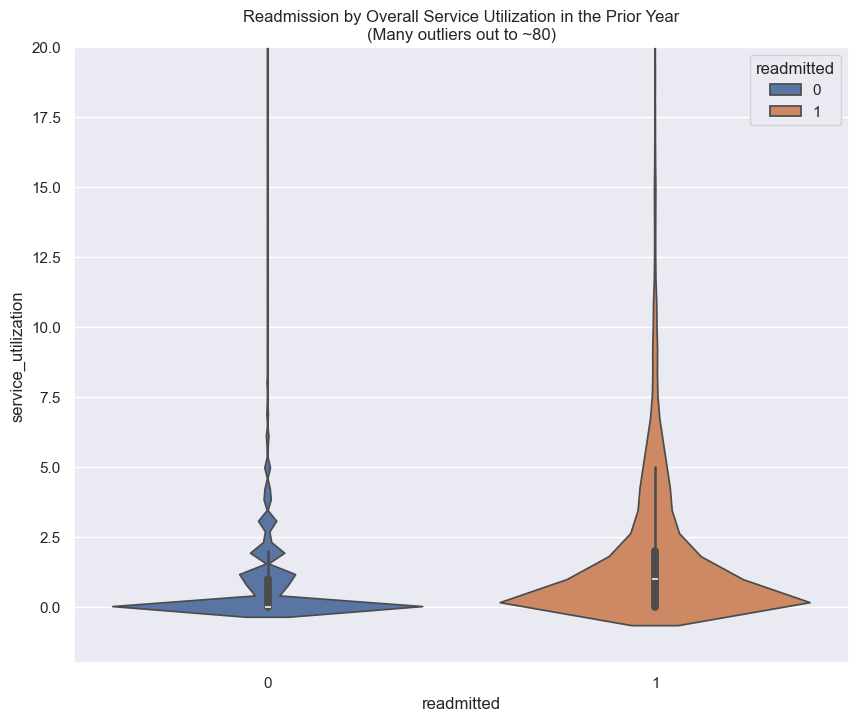

In [27]:
sns.violinplot(data=data, x = "readmitted", y = "service_utilization", hue = 'readmitted')
plt.ylim(-2,20)

plt.title("Readmission by Overall Service Utilization in the Prior Year\n(Many outliers out to ~80)")
plt.show()

## 7. Missing Data Overview

We visualize the missing data structure in the dataset to understand where gaps exist and whether they follow any particular patterns. This helps inform feature selection, imputation strategies (if needed), and how to treat missingness in modeling (e.g., as a signal). Missing data visualization is done on the initial dataset prior to preparation for modeling.

Missingness in this dataset does not appear to be particularly correlated, except on the engineered subspecialty features and with the two secondary diagnoses (if there is no main secondary diagnosis, there will be no additional secondary diagnosis.)

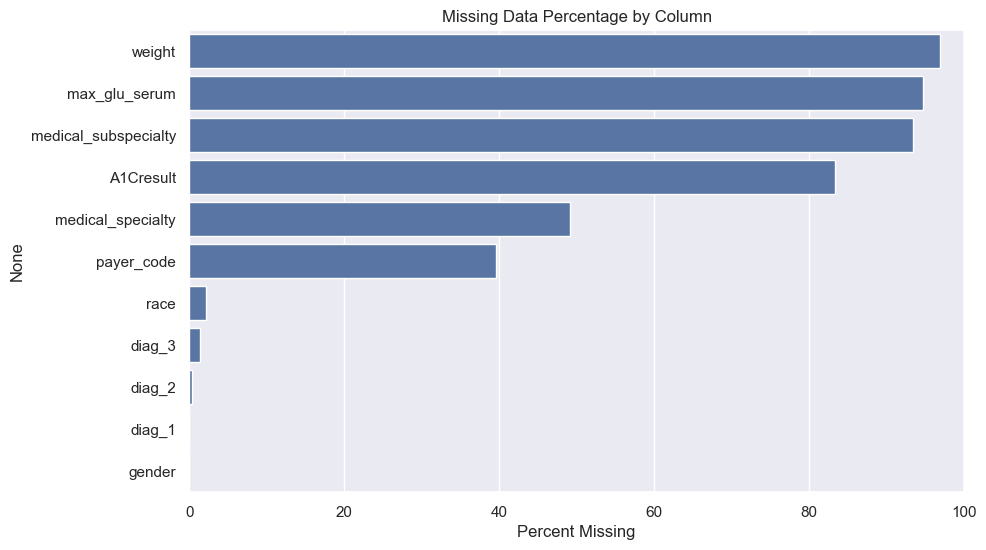

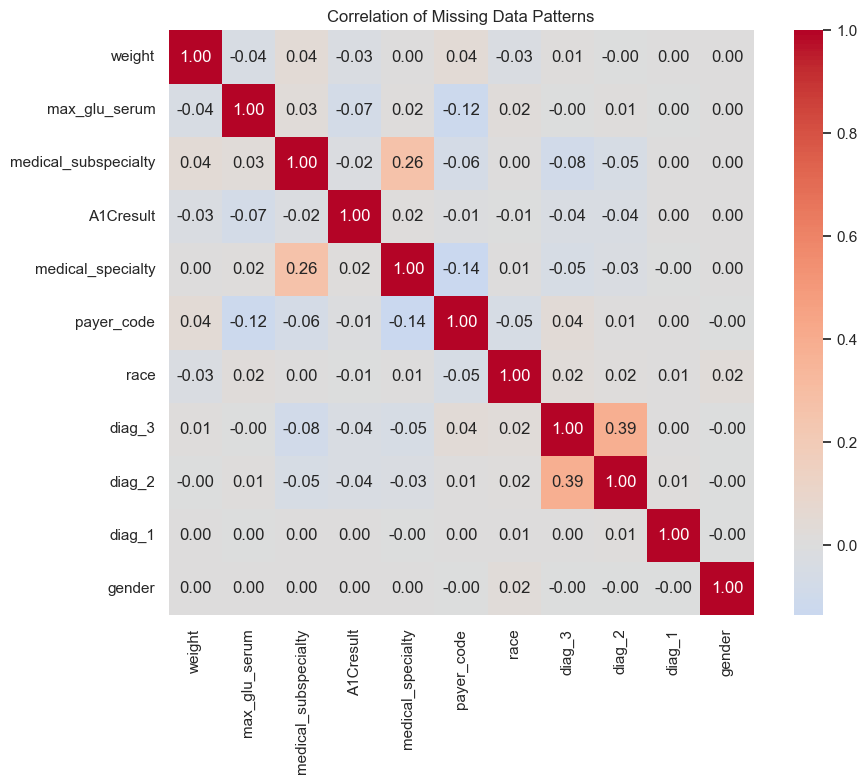

In [28]:
missing_pct = initial_data.isna().mean().sort_values(ascending=False) * 100
missing_pct = missing_pct[missing_pct > 0]  # drop fully populated

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_pct.values, y=missing_pct.index)
plt.xlabel("Percent Missing")
plt.title("Missing Data Percentage by Column")
plt.xlim(0, 100)
plt.show()

# Show which variables tend to be missing together
missing_corr = initial_data[missing_pct.index.to_list()].isna().corr()

plt.figure(figsize=(10, 8))
sns.heatmap(missing_corr, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title("Correlation of Missing Data Patterns")
plt.tight_layout()
plt.show()

## 8. Key Takeaways

This final section summarizes the most relevant visual insights that will shape modeling and feature engineering.

- **Readmission is moderately imbalanced** (~35% positive), justifying binary classification but requiring care in evaluation metrics.

- **Demographic features** (race, gender, age) show limited readmission separation, though age >60 trends slightly higher.

- **Admission and discharge types** reveal stronger patterns, especially discharges to hospice or home care.

- **Clinical specialty and test results** (e.g., A1C, glucose, specialty) could carry important domain signal, but have many missing values. 

- **Medication patterns**, including changes, substitutions, and load, strongly differentiate readmitted patients.

- **Bivariate plots show some interaction effects** among lab procedures, medication counts, and service usage.

- **Missingness is concentrated** in a few clinically relevant fields (A1C, glucose) and may itself carry predictive value.

- **No single numeric variable is strongly correlated** with readmission, reinforcing the need for multivariate or non-linear modeling.